In [250]:
import numpy as np
from typing import Tuple, Callable
import time
import matplotlib.pyplot as plt
import pandas as pd

In [251]:
# Dữ liệu đầu vào
A = np.array([[1, 2],
              [-1, 3],
              [0.5, -2]])
b = np.array([0.1, 0.2, -0.1])

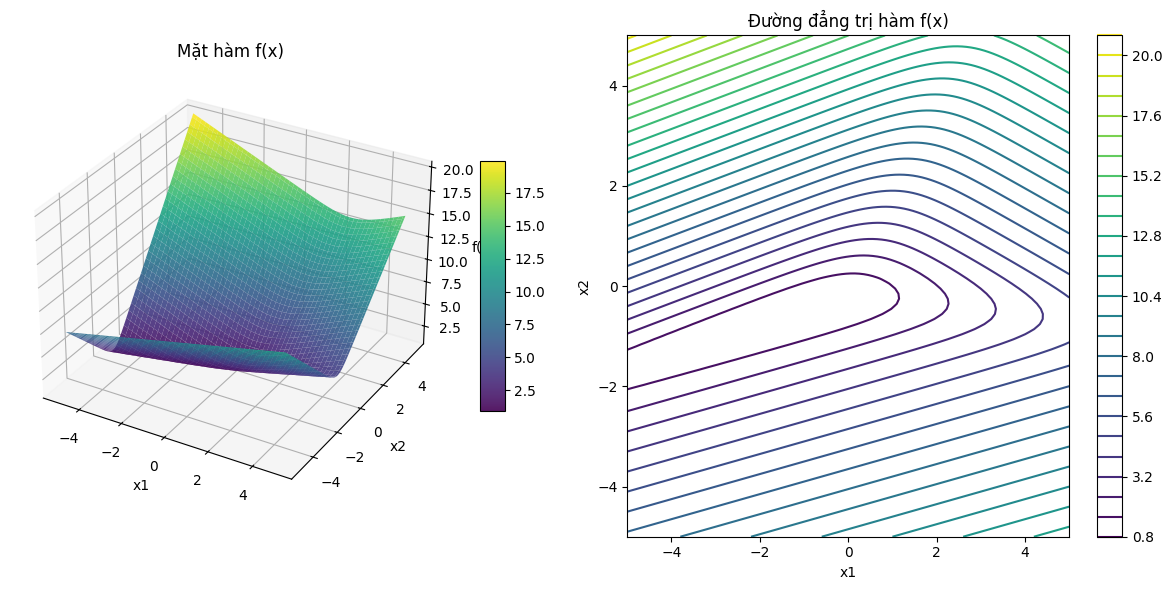

In [252]:
# Cài đặt hàm f(x) đề bài yêu cầu và gradient của hàm f(x)
def f(x: np.ndarray) -> float:
    return np.log(np.sum(np.exp(A @ x + b)))

def grad_f(x: np.ndarray) -> np.ndarray:
    exps = np.exp(A @ x + b)
    return (exps @ A) / np.sum(exps)

def phi_k(t, xk, dk):
    return f(xk - t * dk)

x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1, x2)

Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x = np.array([X1[i, j], X2[i, j]])
        Z[i, j] = f(x)

# Vẽ 2 biểu đồ song song
fig = plt.figure(figsize=(12, 6))

# Bên trái: phác họa đồ thị f(x)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none', alpha=0.9)
ax1.set_title('Mặt hàm f(x)')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10)

# Bên phải: các đường đẳng trị
ax2 = fig.add_subplot(1, 2, 2)
cont = ax2.contour(X1, X2, Z, levels=30, cmap='viridis')
ax2.set_title('Đường đẳng trị hàm f(x)')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
fig.colorbar(cont, ax=ax2)

plt.tight_layout()
plt.show()

# Phương pháp Parabol

In [253]:
def bracket_minimum(phi: Callable, a: float, b: float, step: float = 1e-2) -> Tuple[float, float, float]:
    """
    Tìm đoạn [a,b,c] sao cho phi(b) < phi(a) và phi(b) < phi(c),
    giữ mọi giá trị trong [0,1].
    """
    fa, fb = phi(a), phi(b)
    if fb > fa:
        a, b = b, a
        fa, fb = fb, fa

    c = min(b + step, 1.0)  # giới hạn trong [0,1]
    fc = phi(c)

    while fb > fc and c < 1.0:
        step *= 2
        a, b = b, c
        c = min(c + step, 1.0)  # không vượt quá 1.0
        fa, fb, fc = fb, fc, phi(c)

    return a, b, c

def parabol_line_search(phi: Callable, a: float = 0.0, b: float = 1.0, c: float = 2.0, tol: float = 1e-5, max_iter: int = 100):
    func_calls = 0
    tried_t = []

    # Bước 1: bracket minimum
    a, b, c = bracket_minimum(phi, a, b)
    func_calls += 3
    fa, fb, fc = phi(a), phi(b), phi(c)
    func_calls += 3
    tried_t.extend([a, b, c])

    for _ in range(max_iter):
        denom = (b - a) * (fb - fc) + (b - c) * (fb - fa)
        if denom != 0:
            t = b - 0.5 * ((b - a)**2 * (fb - fc) - (b - c)**2 * (fb - fa)) / denom
        else:
            t = None

        if t is None or not (a < t < c):
            t = 0.5 * (a + c)

        t = max(a, min(c, t))
        t = max(0.0, min(1.0, t))

        ft = phi(t)
        func_calls += 1
        tried_t.append(t)

        if t < b:
            if ft < fb:
                c, fc = b, fb
                b, fb = t, ft
            else:
                a, fa = t, ft
        else:
            if ft < fb:
                a, fa = b, fb
                b, fb = t, ft
            else:
                c, fc = t, ft

        if abs(c - a) < tol:
            break

    return b, func_calls, tried_t

# Phương pháp Brent

In [254]:
def brent_line_search(phi: Callable, a: float = 0.0, b: float = 1.0, tol: float = 1e-5, max_iter: int = 100):
    function_calls = 0
    tried_t = []
    golden_ratio = (3 - np.sqrt(5)) / 2

    x = w = v = a + golden_ratio * (b - a)
    fx = fw = fv = phi(x)
    tried_t.append(x)
    function_calls += 1

    d = e = 0.0

    for k in range(max_iter):
        xm = 0.5 * (a + b)
        tol1 = tol * abs(x) + 1e-10
        tol2 = 2.0 * tol1

        if abs(x - xm) <= (tol2 - 0.5 * (b - a)):
            return x, function_calls, tried_t

        if abs(e) > tol1:
            r = (x - w) * (fx - fv)
            q = (x - v) * (fx - fw)
            p = (x - v) * q - (x - w) * r
            q = 2.0 * (q - r)
            if q > 0:
                p = -p
            q = abs(q)
            etemp = e
            e = d
            parabolic_ok = (abs(p) < abs(0.5 * q * etemp) and 
                            p > q * (a - x) and p < q * (b - x))
            if parabolic_ok:
                d = p / q
                u = x + d
                if (u - a) < tol2 or (b - u) < tol2:
                    d = tol1 if xm - x >= 0 else -tol1
            else:
                e = (a - x) if x >= xm else (b - x)
                d = golden_ratio * e
        else:
            e = (a - x) if x >= xm else (b - x)
            d = golden_ratio * e

        if abs(d) >= tol1:
            u = x + d
        else:
            u = x + (tol1 if d >= 0 else -tol1)

        fu = phi(u)
        tried_t.append(u)
        function_calls += 1

        if fu <= fx:
            if u >= x:
                a = x
            else:
                b = x
            v, w, x = w, x, u
            fv, fw, fx = fw, fx, fu
        else:
            if u < x:
                a = u
            else:
                b = u
            if fu <= fw or w == x:
                v, w = w, u
                fv, fw = fw, fu
            elif fu <= fv or v == x or v == w:
                v = u
                fv = fu

    return x, function_calls, tried_t

# Thuật toán Gradient Descent

In [255]:
def gradient_descent(method: str, x0: np.ndarray, tol: float = 1e-5, max_iter: int = 1000):
    x = np.array(x0, dtype=float)
    k = 0
    total_calls = 0
    converged = False

    history = {
        'iterations': [],
        'fvals': [],
        'grad_norms': [],
        'func_calls': [],
        'moves_per_iter': []
    }

    while k < max_iter:
        g = grad_f(x)
        grad_norm = np.linalg.norm(g)
        fval = f(x)

        history['iterations'].append(k)
        history['fvals'].append(fval)
        history['grad_norms'].append(grad_norm)
        history['func_calls'].append(total_calls)

        if grad_norm < tol:
            converged = True
            break

        def phi(t):
            return f(x - t * g)

        if method == "parabolic":
            a, b, c = np.sort(np.random.rand(3))
            t, calls, tried_t = parabol_line_search(phi, a=a, b=b, c=c, tol=1e-5)
        elif method == "brent":
            a, b = np.sort(np.random.rand(2))
            t, calls, tried_t = brent_line_search(phi, a=a, b=b, tol=1e-5)
        else:
            raise ValueError("Unknown method")

        total_calls += calls
        # print(f"Vòng lặp {k:2d}: t_{k} = {t:.6f}, f(x_{k}) = {f(x):.6f}, ||∇f|| = {grad_norm:.5f}")
        history['moves_per_iter'].append(len(tried_t))  # số lượng t thử

        x = x - t * g
        k += 1

    return x, k, total_calls, converged, history

Lần chạy 1: Nghiệm khởi tạo [-1.25459881  4.50714306]
Parabol: bước lặp = 141, calls = 3887, bước di chuyển t = 3464, time = 0.083613
Brent  : bước lặp = 133, calls = 2400, bước di chuyển t = 2400, time = 0.029697
Lần chạy 2: Nghiệm khởi tạo [-0.74563561  0.07610379]
Parabol: bước lặp = 132, calls = 3528, bước di chuyển t = 3132, time = 0.041339
Brent  : bước lặp = 140, calls = 2469, bước di chuyển t = 2469, time = 0.028939
Lần chạy 3: Nghiệm khởi tạo [-2.62456675  4.71395094]
Parabol: bước lặp = 116, calls = 3440, bước di chuyển t = 3092, time = 0.038785
Brent  : bước lặp = 115, calls = 2083, bước di chuyển t = 2083, time = 0.030376
Lần chạy 4: Nghiệm khởi tạo [-0.65980634 -4.1139957 ]
Parabol: bước lặp = 133, calls = 4140, bước di chuyển t = 3741, time = 0.050389
Brent  : bước lặp = 133, calls = 2398, bước di chuyển t = 2398, time = 0.028656
Lần chạy 5: Nghiệm khởi tạo [-1.39766081 -2.29606714]
Parabol: bước lặp = 157, calls = 3810, bước di chuyển t = 3339, time = 0.043549
Brent  : b

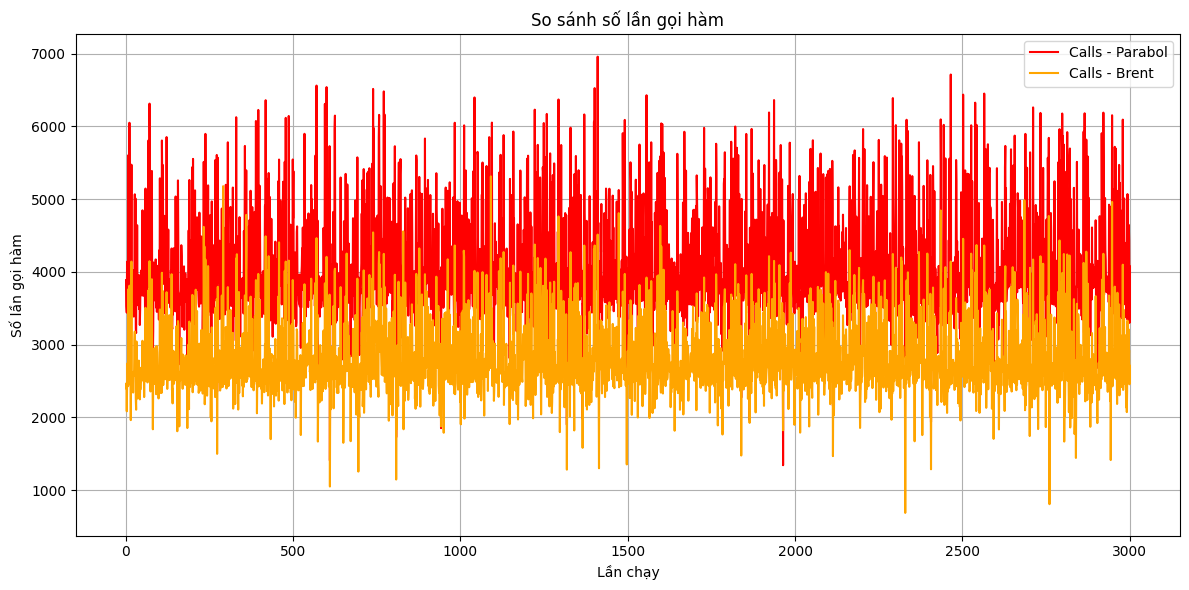

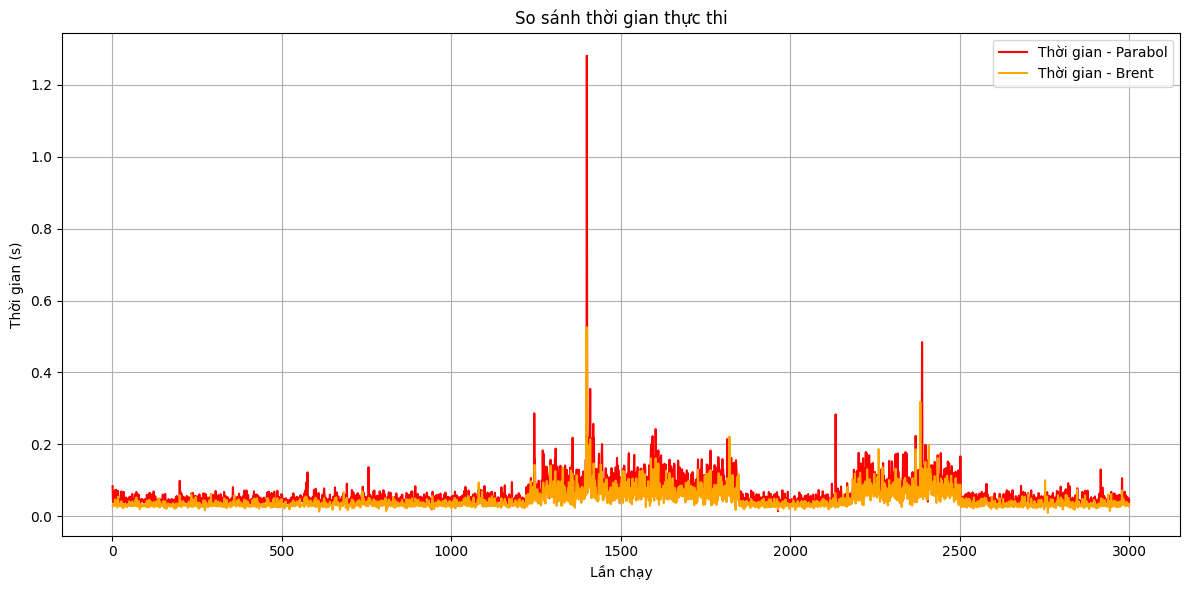

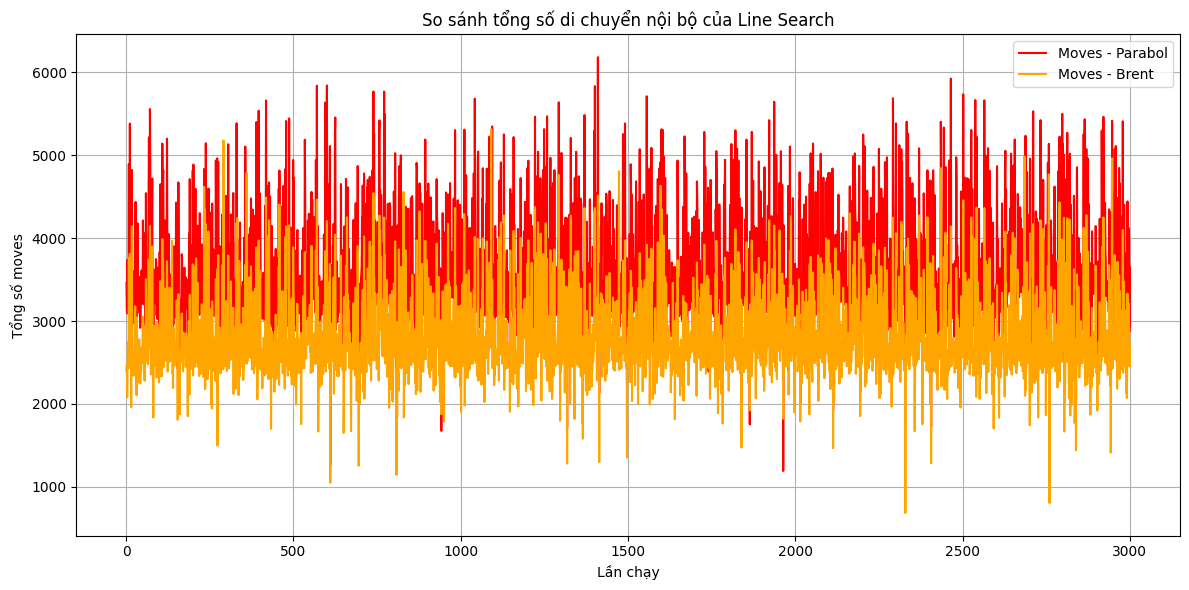

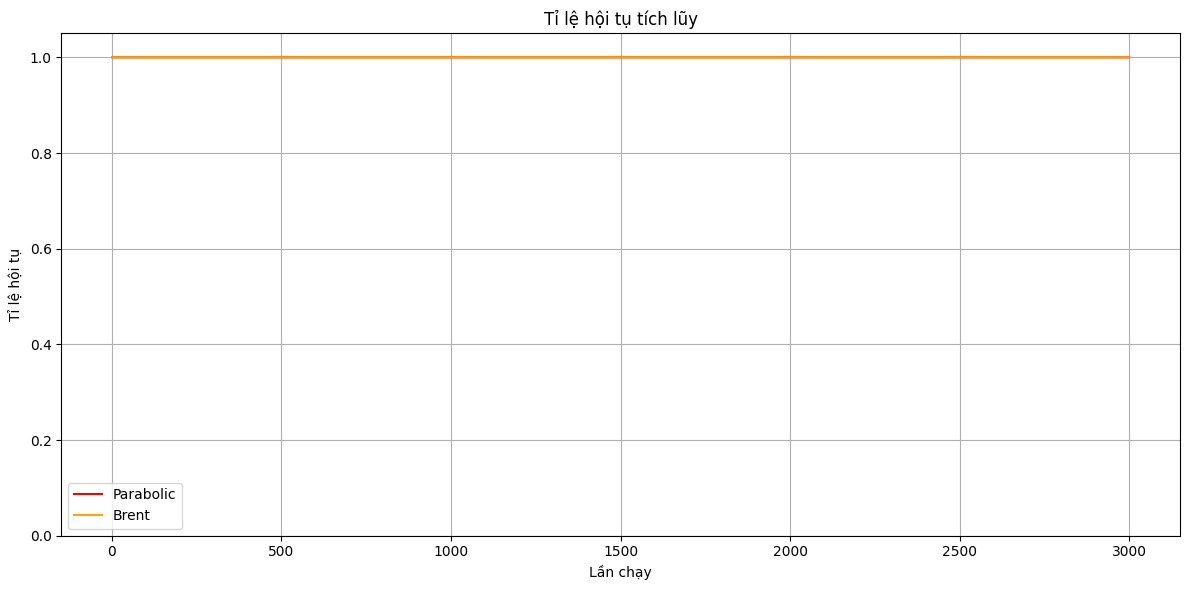

In [256]:
def run_compare_experiments(num_runs: int = 10):
    np.random.seed(42)

    results_parabolic = {'steps': [], 'calls': [], 'times': [], 'converged': [], 'moves': []}
    results_brent = {'steps': [], 'calls': [], 'times': [], 'converged': [], 'moves': []}

    for i in range(num_runs):
        x0 = np.random.uniform(-5, 5, size=2)
        print(f"Lần chạy {i+1}: Nghiệm khởi tạo {x0}")

        # --- Parabol ---
        start_p = time.perf_counter()
        x_opt_p, n_steps_p, n_calls_p, conv_p, hist_p = gradient_descent("parabolic", x0)
        end_p = time.perf_counter()
        moves_total_p = sum(hist_p['moves_per_iter'])
        results_parabolic['steps'].append(n_steps_p)
        results_parabolic['calls'].append(n_calls_p)
        results_parabolic['times'].append(end_p - start_p)
        results_parabolic['converged'].append(conv_p)
        results_parabolic['moves'].append(moves_total_p)
        print(f"Parabol: bước lặp = {n_steps_p}, calls = {n_calls_p}, bước di chuyển t = {moves_total_p}, time = {end_p - start_p:.6f}")

        # --- Brent ---
        start_b = time.perf_counter()
        x_opt_b, n_steps_b, n_calls_b, conv_b, hist_b = gradient_descent("brent", x0)
        end_b = time.perf_counter()
        moves_total_b = sum(hist_b['moves_per_iter'])
        results_brent['steps'].append(n_steps_b)
        results_brent['calls'].append(n_calls_b)
        results_brent['times'].append(end_b - start_b)
        results_brent['converged'].append(conv_b)
        results_brent['moves'].append(moves_total_b)
        print(f"Brent  : bước lặp = {n_steps_b}, calls = {n_calls_b}, bước di chuyển t = {moves_total_b}, time = {end_b - start_b:.6f}")

    runs = range(1, num_runs + 1)

    # --- Vẽ biểu đồ ---
    plt.figure(figsize=(12,6))
    plt.plot(runs, results_parabolic['calls'], label='Calls - Parabol', color='red')
    plt.plot(runs, results_brent['calls'], label='Calls - Brent', color='orange')
    plt.xlabel('Lần chạy'); plt.ylabel('Số lần gọi hàm')
    plt.title('So sánh số lần gọi hàm')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(runs, results_parabolic['times'], label='Thời gian - Parabol', color='red')
    plt.plot(runs, results_brent['times'], label='Thời gian - Brent', color='orange')
    plt.xlabel('Lần chạy'); plt.ylabel('Thời gian (s)')
    plt.title('So sánh thời gian thực thi')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(runs, results_parabolic['moves'], label='Moves - Parabol', color='red')
    plt.plot(runs, results_brent['moves'], label='Moves - Brent', color='orange')
    plt.xlabel('Lần chạy'); plt.ylabel('Tổng số moves')
    plt.title('So sánh tổng số di chuyển nội bộ của Line Search')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    cum_conv_parabolic = np.cumsum(results_parabolic['converged']) / np.arange(1, num_runs+1)
    cum_conv_brent = np.cumsum(results_brent['converged']) / np.arange(1, num_runs+1)
    plt.figure(figsize=(12,6))
    plt.plot(runs, cum_conv_parabolic, label='Parabolic', color='red')
    plt.plot(runs, cum_conv_brent, label='Brent', color='orange')
    plt.xlabel('Lần chạy'); plt.ylabel('Tỉ lệ hội tụ')
    plt.title('Tỉ lệ hội tụ tích lũy')
    plt.ylim(0, 1.05)
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


    df_summary = pd.DataFrame({
        'steps': results_parabolic['steps'] + results_brent['steps'],
        'calls': results_parabolic['calls'] + results_brent['calls'],
        'times': results_parabolic['times'] + results_brent['times'],
        'converged': results_parabolic['converged'] + results_brent['converged'],
        'moves': results_parabolic['moves'] + results_brent['moves'],
        'method': ['Parabolic'] * num_runs + ['Brent'] * num_runs
    })
    df_summary.to_csv('results_comparison.csv', index=False)


run_compare_experiments(num_runs=3000)
